In [366]:
# Import Library
#%reset
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import keras
from glob import glob
from keras.preprocessing.image import ImageDataGenerator #, img_to_array, 
from tensorflow.keras.utils import img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
import os
import pickle
import warnings
warnings.filterwarnings("ignore")
from PIL import Image

#Usare scaler

# Prepare and Review Dataset

In [367]:
# Test and Train path
with open('newResa3.pickle', 'rb') as handle:
    newResa3 = pickle.load(handle)

with open('AllPixelBand3.pickle', 'rb') as handle:
    allPixel3 = pickle.load(handle)

# Identificare qualita' e suddivisione del dataset in maniera corretta tra train e test

 Resa bassa: 58 Resa media[4500,10000]: 1472 Resa alta(>10000): 31


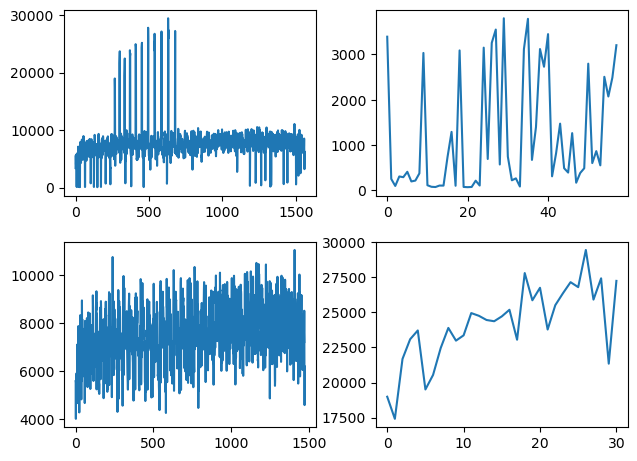

In [368]:
#taglio outliar
FilterResa3gtZero = newResa3!=0
newResa3 = newResa3[FilterResa3gtZero]
allPixel3 = allPixel3[FilterResa3gtZero,:,:]

LowValue = 1
Medium = 4000
HighValue = 12000
Resa3LowFilter = (newResa3<Medium) & (newResa3>LowValue)
Resa3MediumFilter = (newResa3>=Medium) & (newResa3<=HighValue)
Resa3HighFilter = (newResa3>HighValue)

Resa3Low = newResa3[Resa3LowFilter]
Resa3Medium = newResa3[Resa3MediumFilter]
Resa3High = newResa3[Resa3HighFilter]

Pixel3Low = allPixel3[Resa3LowFilter,:,:]
Pixel3Medium = allPixel3[Resa3MediumFilter,:,:]
Pixel3High = allPixel3[Resa3HighFilter,:,:]


print(" Resa bassa: "+str(len(Resa3Low))+ " Resa media[4500,10000]: "+ str(len(Resa3Medium))+ " Resa alta(>10000): "+ str(len(Resa3High)))

padding = 1.2
f, axarr = plt.subplots(2,2)
f.tight_layout(pad=padding)
axarr[0][0].plot(newResa3)
axarr[0][1].plot(Resa3Low)
axarr[1][0].plot(Resa3Medium)
axarr[1][1].plot(Resa3High)
plt.show()

In [369]:
Resa3Medium = Resa3Medium/Resa3Medium.max()

1185


(array([ 1.,  4.,  3.,  4., 10., 14., 18., 23., 26., 28., 21., 16.,  7.,
        21., 25., 21., 28., 22., 34., 42., 16., 26., 25., 21., 20., 22.,
        34., 44., 26., 19., 10.,  5.,  3.,  1.,  1.,  1.]),
 array([0.36391   , 0.38157916, 0.39924833, 0.4169175 , 0.43458664,
        0.45225582, 0.469925  , 0.48759416, 0.5052633 , 0.52293247,
        0.5406017 , 0.5582708 , 0.57594   , 0.59360915, 0.61127836,
        0.6289475 , 0.64661664, 0.66428584, 0.681955  , 0.6996242 ,
        0.7172933 , 0.7349625 , 0.75263166, 0.7703008 , 0.78797   ,
        0.80563915, 0.82330835, 0.8409775 , 0.8586467 , 0.87631583,
        0.893985  , 0.9116542 , 0.9293233 , 0.9469925 , 0.96466166,
        0.98233086, 1.        ], dtype=float32),
 <a list of 36 Patch objects>)

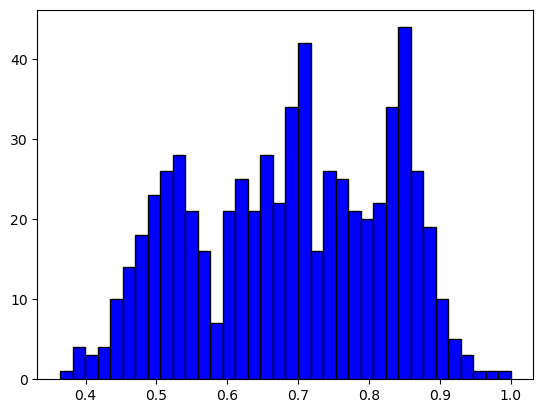

In [370]:
Resa3Undesampling = (Resa3Medium>=0.55) & (Resa3Medium<=0.83)

trueList = np.argwhere(Resa3Undesampling == True).flatten()
print(trueList.shape[0])
falseList = np.argwhere(Resa3Undesampling == False).flatten()
flipToFalse = np.random.choice(range(trueList.shape[0]), size=(int(trueList.shape[0]*0.3),), replace=False)

SampleList = np.concatenate((falseList,trueList[flipToFalse]))

Resa3Sampled = Resa3Medium[SampleList]
Pixel3Sampled = Pixel3Medium[SampleList,:,:]
import seaborn as sns
plt.hist(Resa3Sampled, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

(642, 12, 30)
(642, 30)


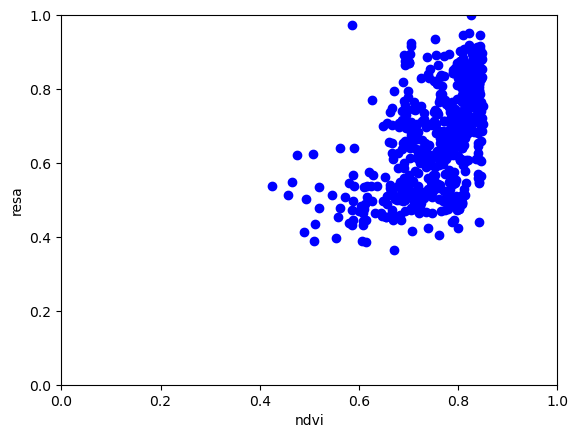

In [371]:
Pixel3MediumPlt = np.array(Pixel3Sampled)
print (Pixel3MediumPlt.shape)
NVDI3Medium = np.array((Pixel3MediumPlt[:,7,:]-Pixel3MediumPlt[:,3,:])/(Pixel3MediumPlt[:,7,:]+Pixel3MediumPlt[:,3,:]))

print(NVDI3Medium.shape)

fig, ax = plt.subplots()
ax.scatter(NVDI3Medium[:,12], Resa3Sampled, c='blue')
ax.set_xlabel("ndvi")
ax.set_ylabel("resa")
ax.set_ylim([0,1])
ax.set_xlim([0,1])
plt.show()

In [372]:
def ResaIdeale(ndviPicco,rumore):  
    
    ideale = ((ndviPicco**1.6)/2.3)+0.4

    return np.random.normal(loc=ideale, scale=rumore, size=None)

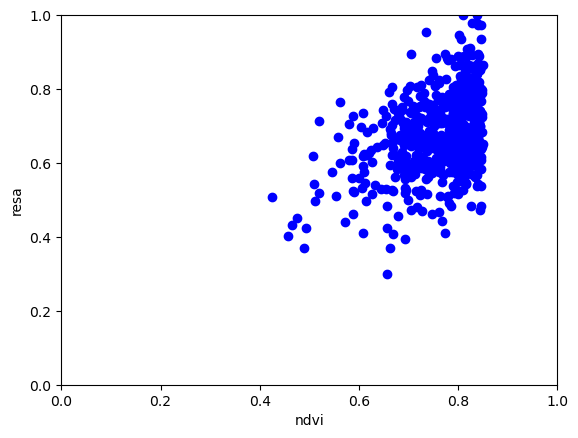

In [373]:
Resa3MediumFake = []
rumore = 0.1
#rumore a 0.1 assomiglia molto alla resa REALE!!!

for v in (NVDI3Medium[:,12]):
    Resa3MediumFake.append(ResaIdeale(v,rumore))

Resa3MediumFake = np.array(Resa3MediumFake)
fig, ax = plt.subplots()
ax.scatter(NVDI3Medium[:,12], Resa3MediumFake, c='blue')
ax.set_xlabel("ndvi")
ax.set_ylabel("resa")
ax.set_ylim([0,1])
ax.set_xlim([0,1])
plt.show()

# Costruisco le immagini

In [374]:
def splitSet(X,Y):
    if X.shape[0] != Y.shape[0]:
        raise Exception("X and Y have different sizes")
    choice = np.random.choice(range(X.shape[0]), size=(int(X.shape[0]/2),), replace=False)
    ind = np.zeros(X.shape[0], dtype=bool)
    ind[choice] = True
    rest = ~ind
    return np.array(X[ind,:,:]),np.array(Y[ind]),np.array(X[rest,:,:]),np.array(Y[rest])

[0.43727404 0.52304775 0.5298626  0.5090383  0.48341468 0.5065347
 0.8442697  0.47494575 0.4576916  0.5131779 ]


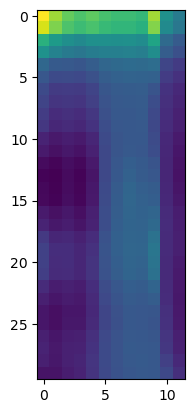

In [375]:
# Test and Train path
train_path = "dataset\\train\\"
test_path = "dataset\\test\\"

#training_setLowX, training_setLowY, test_setLowX, test_setLowY = splitSet(Pixel3Low,Resa3Low)
training_setMediumX,training_setMediumY, test_setMediumX, test_setMediumY = splitSet(Pixel3Sampled,Resa3Sampled)
#training_setHighX,training_setHighY, test_setHighX, test_setHighY = splitSet(Pixel3High,Resa3High)

#training_setX = np.concatenate([training_setLowX,training_setMediumX,training_setHighX],axis=0)
#training_setY = np.concatenate([training_setLowY,training_setMediumY,training_setHighY],axis=0)
training_setX = training_setMediumX
training_setY = training_setMediumY

#test_setX = np.concatenate([test_setLowX,test_setMediumX,test_setHighX],axis=0)
#test_setY = np.concatenate([test_setLowY,test_setMediumY,test_setHighY],axis=0)
test_setX = test_setMediumX
test_setY = test_setMediumY

print(training_setY[10:20])
plt.imshow(np.transpose(training_setX[0,:,:]))

#Train Set
for a in range(0,training_setX.shape[0]):
    img = Image.fromarray(training_setX[a,:,:])
    img.save(train_path+str(a)+'.tiff')

#Test Set
for a in range(0,test_setX.shape[0]):
    img = Image.fromarray(test_setX[a,:,:])
    img.save(test_path+str(a)+'.tiff')


In [376]:
print(training_setMediumX.shape)

(321, 12, 30)


# Image Enhance

In [377]:
def multiplyImg(img):
    newImg = np.concatenate((img,img,img),axis = 1)
    newImg = np.concatenate((newImg,newImg),axis = 2)
    newImg = np.stack([newImg,newImg,newImg], axis=3)
    return newImg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(321, 36, 60, 3)


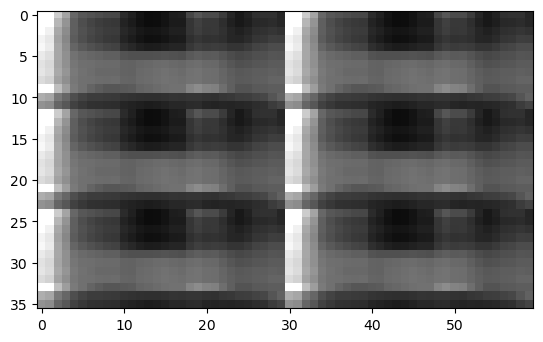

In [378]:
training_setMediumX = multiplyImg(training_setMediumX)
test_setMediumX = multiplyImg(test_setMediumX)
print(training_setMediumX.shape)
plt.imshow(training_setMediumX[0])

TIFF
(30, 12)
F
[[1.2787415  1.2026472  0.802232   0.6438731  0.40755248 0.34302142
  0.32456794 0.30281428 0.28622136 0.27859262 0.17003737 0.12675677
  0.07459642 0.0473698  0.05255626 0.07670014 0.11678174 0.12342671
  0.27732995 0.34015468 0.29759514 0.29797804 0.23285212 0.14571954
  0.0966497  0.13171338 0.18578021 0.19253628 0.1922283  0.1470561 ]
 [1.1216325  1.0589129  0.71581566 0.58210033 0.37309346 0.30698293
  0.26850066 0.24191488 0.22458366 0.2187761  0.13974804 0.10746191
  0.06868701 0.04835839 0.05450862 0.07525745 0.10591483 0.10928212
  0.2114581  0.2527424  0.21977589 0.22119586 0.1836832  0.12611492
  0.09561189 0.12027629 0.157934   0.16458875 0.17563348 0.15102938]
 [1.0000618  0.9483542  0.6615016  0.5500662  0.37433955 0.3184717
  0.282437   0.2576866  0.23838508 0.23149711 0.1594899  0.1306683
  0.09768929 0.08029673 0.08426347 0.10159212 0.12568961 0.12726414
  0.21056762 0.24469058 0.21886127 0.22120053 0.19552816 0.15039678
  0.1292662  0.1520241  0.186566

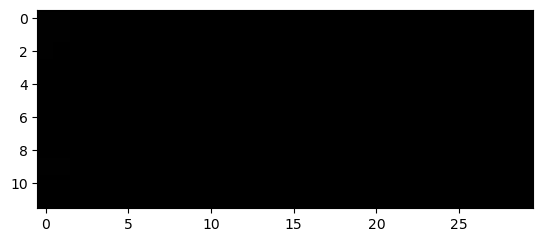

In [379]:
import cv2
path = "dataset\\train\\0.tiff"
# load and show an image with Pillow
from PIL import Image
# Open the image form working directory
image = Image.open(path)
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)
# show the image
from numpy import asarray
data = asarray(image)
print(data)
plt.imshow(image)
plt.show()


In [380]:


# Costruiamo un dataframe Train
dFTrain = pd.DataFrame(columns=['id','target'])
dFTrain['id'] = [str(x)+".tiff" for x in list(range(0,training_setX.shape[0]))]
dFTrain['target'] = training_setY
print(dFTrain.head())

# Costruiamo un dataframe Test
dFTest = pd.DataFrame(columns=['id','target'])
dFTest['id'] = [str(x)+".tiff" for x in list(range(0,test_setX.shape[0]))]
dFTest['target'] = test_setY
inputSize = (36,60)
# Prepare the dataset
#Train dataset
#train_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTrain, target_size = inputSize,
#                                                      directory=train_path,
#                                                      x_col="id",
#                                                      y_col="target",
#                                                      class_mode="other")
#
##Test Dataset
#test_data = ImageDataGenerator().flow_from_dataframe(dataframe=dFTest, target_size = inputSize,
#                                                      directory=test_path,
#                                                      x_col="id",
#                                                      y_col="target",
#                                                      class_mode="other")


       id    target
0  0.tiff  0.498988
1  1.tiff  0.492787
2  2.tiff  0.535213
3  3.tiff  0.510286
4  4.tiff  0.509038
Found 321 validated image filenames.
Found 321 validated image filenames.


In [381]:
loadedImg =[]
for _ in range(len(train_data.filenames)):
     image, label = train_data.next()
     # display the image from the iterator
     print(image.shape)
     loadedImg.append(image[0])
     #plt.imshow(image[0])
     #label_name=label[0] # note you are only showing the first image of the batch
     #plt.title(label_name)
     #plt.show()


#for images, labels in train_data.batch_index():
#  for i in range(9):
#    ax = plt.subplot(3, 3, i + 1)
#    plt.imshow(images[i].numpy().astype("uint8"))
#    plt.title(train_data[i])
#    plt.axis("off")


(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(1, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(1, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(1, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(1, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(1, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 3)
(32, 36, 60, 

In [382]:
print(dFTrain['target'].mean())
print(dFTrain['target'].median())

print(dFTest['target'].mean())
print(dFTest['target'].median())

0.6916053295135498
0.702277660369873
0.6831965446472168
0.6942154765129089


# Creazione del modello di Vgg16

In [383]:
# Import model
vgg16 = VGG16(input_shape=inputSize+(3,),include_top=False)

# Import model
#vgg16 = VGG16()

In [384]:
# add the layers of vgg16 in my created model.
vgg16Model = Sequential()
for i in range(len(vgg16.layers)-1):
    vgg16Model.add(vgg16.layers[i])


In [385]:
# Close the layers of vgg16
for layers in vgg16Model.layers[:-3]:
    layers.trainable = False

In [386]:

# Last layer
vgg16Model.add(Flatten())
vgg16Model.add(Dense(4096,activation='relu',name='fc0'))
vgg16Model.add(Dense(2048,activation='relu',name='fc1'))
vgg16Model.add(Dense(1024,activation='relu',name='fc2'))
vgg16Model.add(Dense(512,activation='relu',name='fc3'))
vgg16Model.add(Dense(256,activation='relu',name='fc4'))
vgg16Model.add(Dense(128,activation='relu',name='fc5'))
vgg16Model.add(Dense(64,activation='relu',name='fc6'))
vgg16Model.add(Dense(32,activation='relu',name='fc7'))
vgg16Model.add(Dense(1,activation='linear'))

In [387]:
# After I added last layer in created model.
vgg16Model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 36, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 36, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 18, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 18, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 18, 30, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 9, 15, 128)        0         
                                                                 
 block3_conv1 (Conv2D)       (None, 9, 15, 256)      

In [388]:
# I create compile part.
vgg16Model.compile(loss = "mean_squared_error",
             optimizer = 'adam',
             metrics = ["mse","mae"])

# Training Model 

In [389]:
# Traning with model
batch_size = 32
#training_setMediumY, test_setMediumX, test_setMediumY
hist_vgg16 = vgg16Model.fit(x=training_setMediumX,y=training_setMediumY,
                                epochs = 30,
                                validation_data=(test_setMediumX,test_setMediumY)
                                )

Epoch 1/30
11/11 [==============================] - 9s 615ms/step - loss: 18.2046 - mse: 18.2046 - mae: 1.5558 - val_loss: 0.1165 - val_mse: 0.1165 - val_mae: 0.3128
Epoch 2/30
11/11 [==============================] - 6s 582ms/step - loss: 0.0445 - mse: 0.0445 - mae: 0.1733 - val_loss: 0.0427 - val_mse: 0.0427 - val_mae: 0.1666
Epoch 3/30
11/11 [==============================] - 6s 603ms/step - loss: 0.0284 - mse: 0.0284 - mae: 0.1400 - val_loss: 0.0905 - val_mse: 0.0905 - val_mae: 0.2681
Epoch 4/30
11/11 [==============================] - 6s 587ms/step - loss: 0.0489 - mse: 0.0489 - mae: 0.1831 - val_loss: 0.0190 - val_mse: 0.0190 - val_mae: 0.1183
Epoch 5/30
11/11 [==============================] - 6s 581ms/step - loss: 0.0323 - mse: 0.0323 - mae: 0.1480 - val_loss: 0.0227 - val_mse: 0.0227 - val_mae: 0.1272
Epoch 6/30
11/11 [==============================] - 6s 580ms/step - loss: 0.0209 - mse: 0.0209 - mae: 0.1172 - val_loss: 0.0187 - val_mse: 0.0187 - val_mae: 0.1169
Epoch 7/30
11/

In [395]:
# Save the weights of model
vgg16Model.save_weights("previsioneOttima.h5")

# Andiamo a visualizzare i risultati della rete

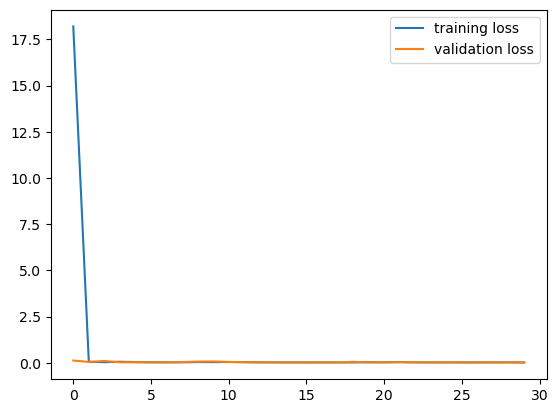

In [391]:
# Loss and Validation Loss
plt.plot(hist_vgg16.history["loss"], label = "training loss")
plt.plot(hist_vgg16.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

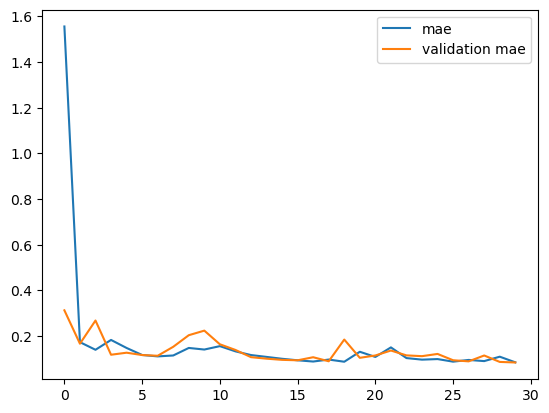

In [392]:
# Accuracy and Validation Accuracy
plt.plot(hist_vgg16.history["mae"], label = "mae")
plt.plot(hist_vgg16.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [393]:
import os
import glob


predict_path = "dataset\\predict\\"

files = glob.glob(predict_path+'\\0\\*')
for f in files:
    os.remove(f)

true_y = dFTest['target'].values
print(len(true_y))                                               
pred_y = vgg16Model.predict(test_setMediumX)



321
11/11 [==============================] - 2s 147ms/step


NameError: name 'pred_y' is not defined

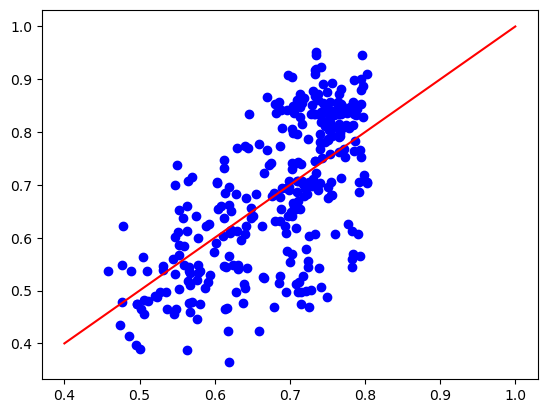

In [394]:

import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

#
#lineStart = data_calc_hourly.temp.min() 
#lineEnd = data_calc_hourly.temp.max()  
fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
#line.set_transform(transform)
ax.add_line(line)
plt.show()


# Salviamo e carichiamo i risultati

In [396]:
import json, codecs
with open("previsioneResa.json","w") as f:
    json.dump(hist_vgg16.history, f)

In [152]:
'''with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:
    load_result = json.loads(f.read())'''

'with codecs.open("./previsioneResa.json","r", encoding = "utf-8") as f:\n    load_result = json.loads(f.read())'

# Vgg19

In [397]:
# Import VGG19 model
vgg19 = VGG19(input_shape=inputSize+(3,),include_top=False)

In [398]:
# Layers of vgg19
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 36, 60, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 36, 60, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 36, 60, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 18, 30, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 18, 30, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 18, 30, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 9, 15, 128)        0     

In [400]:
# add the layers of vgg16 in my created model.
vgg19Model = Sequential()
vgg19Model.add(vgg19)

In [401]:
# Close the layers of vgg16
for layers in vgg19Model.layers:
    layers.trainable = False

In [405]:
# Last layer
vgg19Model.add(Flatten())
vgg19Model.add(Dense(4096,activation='relu'))
vgg19Model.add(Dense(2048,activation='relu'))
vgg19Model.add(Dense(1024,activation='relu'))
vgg19Model.add(Dense(512,activation='relu'))
vgg19Model.add(Dense(256,activation='relu'))
vgg19Model.add(Dense(128,activation='relu'))
vgg19Model.add(Dense(64,activation='relu'))
vgg19Model.add(Dense(32,activation='relu'))
vgg19Model.add(Dense(1,activation='linear'))

In [406]:
# the final version of the model
vgg19Model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_16 (Flatten)        (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 4096)              2101248   
                                                                 
 dense_23 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_24 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_25 (Dense)            (None, 512)               524800    
                                                                 
 dense_26 (Dense)            (None, 256)             

In [407]:
# I create compile part.
vgg19Model.compile(loss = "mean_squared_error",
             optimizer = "adam",
             metrics = ["mse","mae"])

# Addestramento

In [409]:
# Training with my created model
hisy_vgg19 = vgg19Model.fit(x=training_setMediumX,y=training_setMediumY,
                                epochs = 30,
                                validation_data=(test_setMediumX,test_setMediumY)
                               )

Epoch 1/30
11/11 [==============================] - 6s 437ms/step - loss: 0.3168 - mse: 0.3168 - mae: 0.4777 - val_loss: 0.1893 - val_mse: 0.1893 - val_mae: 0.4124
Epoch 2/30
11/11 [==============================] - 4s 407ms/step - loss: 0.0463 - mse: 0.0463 - mae: 0.1601 - val_loss: 0.1118 - val_mse: 0.1118 - val_mae: 0.3078
Epoch 3/30
11/11 [==============================] - 4s 420ms/step - loss: 0.0361 - mse: 0.0361 - mae: 0.1546 - val_loss: 0.0423 - val_mse: 0.0423 - val_mae: 0.1704
Epoch 4/30
11/11 [==============================] - 4s 415ms/step - loss: 0.0252 - mse: 0.0252 - mae: 0.1303 - val_loss: 0.0324 - val_mse: 0.0324 - val_mae: 0.1470
Epoch 5/30
11/11 [==============================] - 5s 427ms/step - loss: 0.0197 - mse: 0.0197 - mae: 0.1123 - val_loss: 0.0147 - val_mse: 0.0147 - val_mae: 0.1010
Epoch 6/30
11/11 [==============================] - 5s 443ms/step - loss: 0.0195 - mse: 0.0195 - mae: 0.1116 - val_loss: 0.0120 - val_mse: 0.0120 - val_mae: 0.0900
Epoch 7/30
11/11

# Visualizziamo i risultati ottenuti

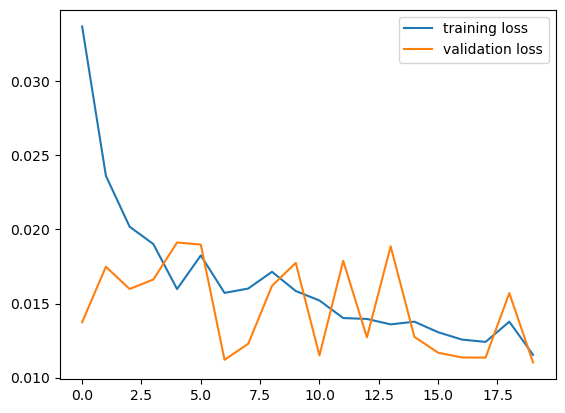

In [ ]:
# Loss And Validation Loss
plt.plot(hisy_vgg19.history["loss"], label = "training loss")
plt.plot(hisy_vgg19.history["val_loss"], label = "validation loss")
plt.legend()
plt.show()

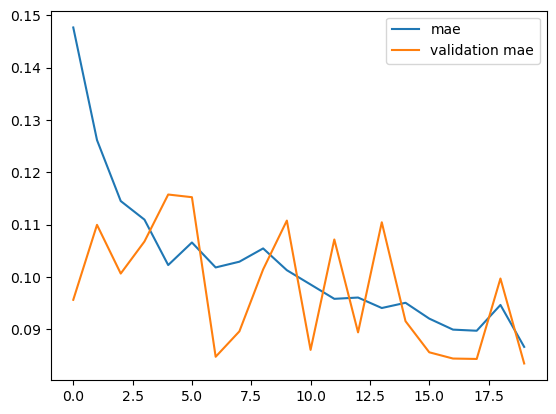

In [ ]:
# Accuracy And Validation Accuracy
plt.plot(hisy_vgg19.history["mae"], label = "mae")
plt.plot(hisy_vgg19.history["val_mae"], label = "validation mae")
plt.legend()
plt.show()

In [410]:
true_y = test_setMediumY
print(len(true_y)) 
pred_y = vgg19Model.predict(test_setMediumX)

321
11/11 [==============================] - 2s 156ms/step


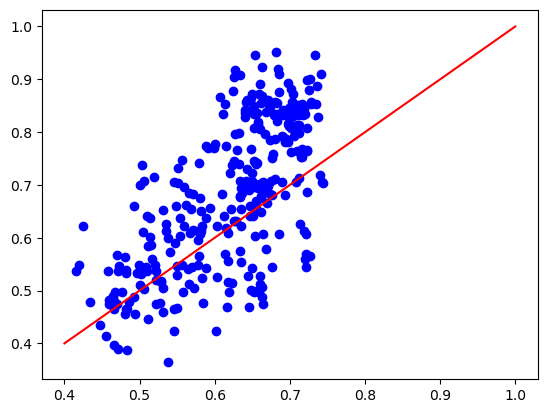

In [411]:
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

#
#lineStart = data_calc_hourly.temp.min() 
#lineEnd = data_calc_hourly.temp.max()  
fig, ax = plt.subplots()
ax.scatter(pred_y, true_y, c='blue')
line = mlines.Line2D([0.4, 1], [0.4, 1], color='red')
transform = ax.transAxes
#line.set_transform(transform)
ax.add_line(line)
plt.show()                      

In [412]:
# Save the weights of model
vgg19Model.save_weights("previsioneOttimavgg19.h5")
import json, codecs
with open("previsioneResavgg19.json","w") as f:
    json.dump(hisy_vgg19.history, f)